# LDA. BERTopic

## Table of contents

In [1]:
import transformers
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import pandas as pd
import numpy as np
from danlp.models import load_bert_emotion_model
from bertopic import BERTopic
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tqdm import tqdm
import umap
import hdbscan
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
torch.cuda.get_device_name()

'NVIDIA GeForce GTX 1650'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def create_wordcloud(topic_model, topic):
    text = {word: value for word, value in topic_model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

def create_wordcloud_lda(topic):
    text = {word: value for word, value in topic}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [5]:
SCRAPPED_DATA_PATH = './scrapped_data/scrapped_data_extended.csv'
MODELS_DATA_PATH = "./models"

In [47]:
df = pd.read_csv(SCRAPPED_DATA_PATH)

In [7]:
df.isna().sum().sum()

0

## Preprocessing

In [9]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to C:\Users\Aleksey
[nltk_data]     Ryabykin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Aleksey
[nltk_data]     Ryabykin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Aleksey
[nltk_data]     Ryabykin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Aleksey
[nltk_data]     Ryabykin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [10]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
# from nltk.corpus import wordnet 
docs = df.pure_text.values
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')
stop_words = stopwords.words('english')
#lets extend it by very common words for the our realm
new_stopwords = ['one', 'two', 'three',
                'we', 'like', 'also', 'use',
                'value', 'dataset', 'target',
                'data', 'learning', 'model',
                'variable', 'using', 'training',
                'time', 'feature', 'linear',
                'code', 'function', 'object',
                'variables', 'bounding', 'used',
                'assistants', 'layer', 'input',
                'ha', 'make', 'get', 'box', 
                'class', 'system', 'ga', 'di',
                'people', 'need', 'see', 'wa',
                'state', 'weight', 'scale',
                'company', 'network', 'gradient',
                'vector', 'file', 'size', 'train',
                'map', 'output', 'let', 'example',
                'first', 'number', 'different',
                'article', 'algorithm', 'de',
                'error', 'generator', 'loss',
                'building', 'build', 'problem',
                'want', 'take', 'let', 'step', 
                'che', 'un', 'parameter', 'process',
                'mean', 'ai', 'really', 'point',
                'would', 'method', 'new',
                'update', 'result', 'prediction',
                'series', 'way', 'many', 'learn', 
                'set', 'find', 'work', 'approach',
                'pdf', 'shot' 'cluster', 'result',
                'neural', 'based', 'good', 'much', 
                'part', 'case', 'based', 'iteration',
                'machine', 'change', 'deep', 'question',
                'day', 'know', 'document', 'thought',
                'think', 'rate', 'shot', 'agent',
                'la', 'well', 'next', 'yang', 'even',
                'style', 'task', 'entry', 'project', "thing",
                'word', 'ar', 'writing', 'user'
]
stop_words.extend(new_stopwords)
filtered_docs = []
for sent in tqdm(docs):
    word_tokens = tokenizer.tokenize(sent)
    
    filtered_sentence = [lemmatizer.lemmatize(w) for w in word_tokens if not (lemmatizer.lemmatize(w.lower()) in stop_words) and not (w.lower() in stop_words) and not w.isdigit()]
    filtered_docs.append(' '.join(filtered_sentence))

100%|██████████| 9933/9933 [01:04<00:00, 153.68it/s]


## Latent Dirichlet Allocation

### Math behind

In [11]:
# from sklearn tutorial

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_[:10]):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [12]:
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words=stop_words)
dtm = cv.fit_transform(filtered_docs)
lda = LatentDirichletAllocation(n_components=12, verbose=1)
probs = lda.fit_transform(dtm)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


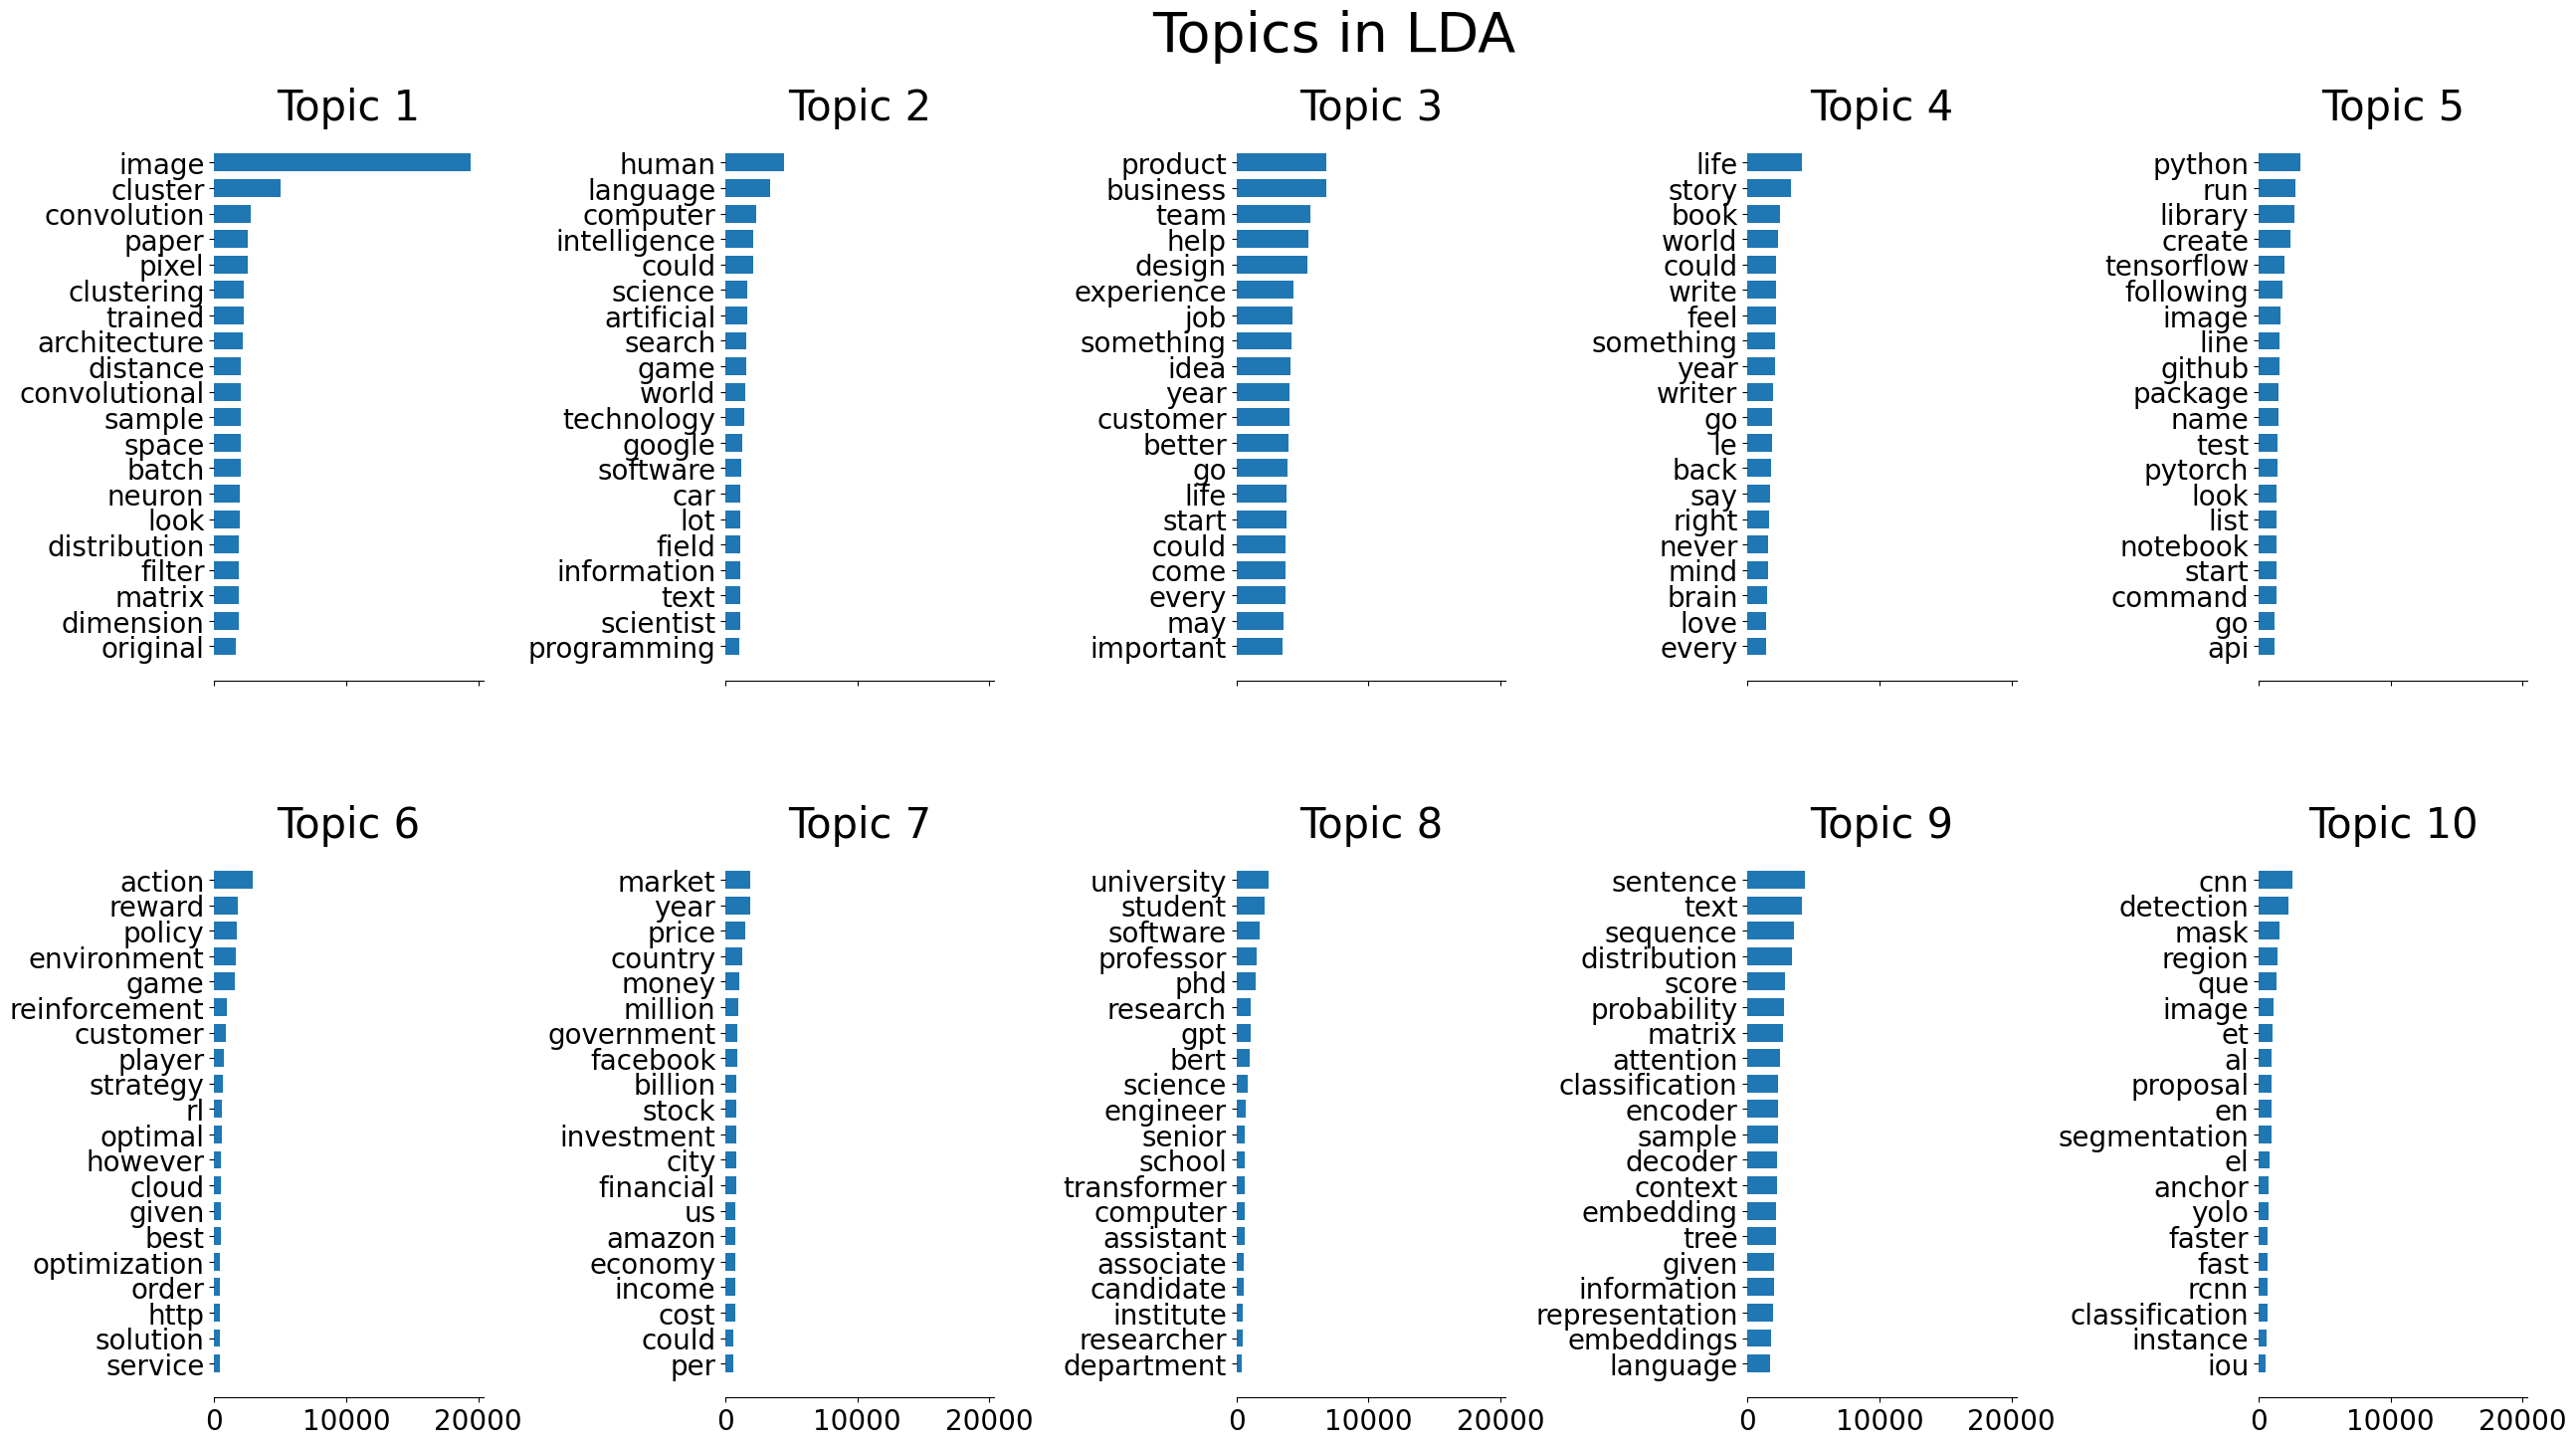

In [13]:
plot_top_words(lda, cv.get_feature_names_out(), 20, "Topics in LDA")

In [53]:
def get_topics(model, feature_names, n_top_words, n_components):
    topics = []
    for topic_idx, topic in enumerate(model.components_[:n_components]):
            top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]
            topics.append([(name, prob) for name, prob in zip(top_features, weights)])
    return topics

In [54]:
topics = get_topics(lda, cv.get_feature_names_out(), 20, 10)

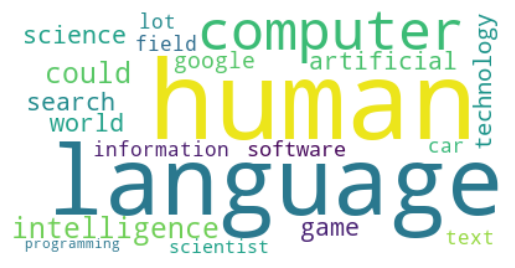

In [55]:
create_wordcloud_lda(topics[1])

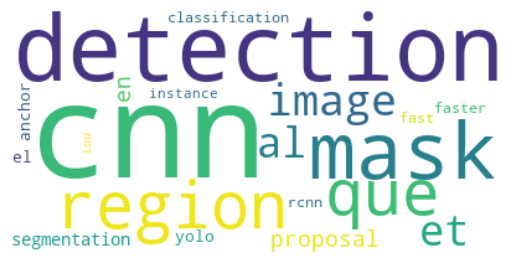

In [61]:
create_wordcloud_lda(topics[-1])

## BERTopic

### Method description

### Hand-made BERTopic

In [82]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens', device=device)
embeddings = model.encode(filtered_docs, show_progress_bar=True, device=device)

Batches:   0%|          | 0/311 [00:00<?, ?it/s]

In [74]:
reduced_embeddings = umap.UMAP(n_neighbors=10, 
                            n_components=5, verbose=True,
                            metric='cosine').fit_transform(embeddings)

UMAP(angular_rp_forest=True, metric='cosine', n_components=5, n_neighbors=10, verbose=True)
Tue Dec 20 05:58:01 2022 Construct fuzzy simplicial set
Tue Dec 20 05:58:01 2022 Finding Nearest Neighbors
Tue Dec 20 05:58:01 2022 Building RP forest with 10 trees
Tue Dec 20 05:58:03 2022 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	 6  /  13
	 7  /  13
	Stopping threshold met -- exiting after 7 iterations
Tue Dec 20 05:58:04 2022 Finished Nearest Neighbor Search
Tue Dec 20 05:58:04 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Tue Dec 20 05:58:10 2022 Finished embedding


In [75]:
cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(reduced_embeddings)

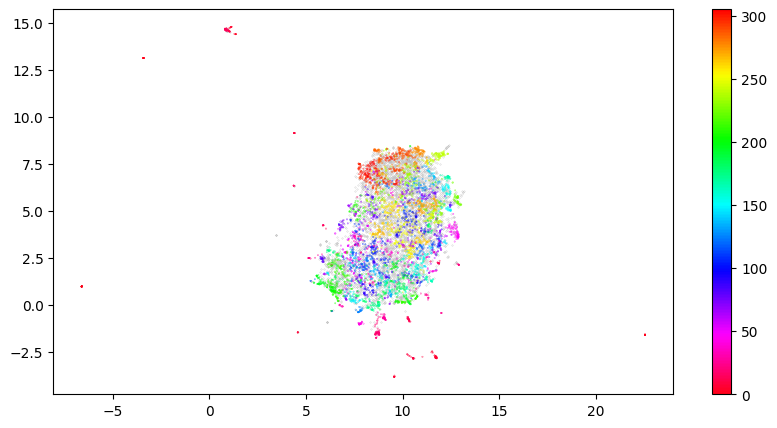

In [80]:
umap_data = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0.1, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(10, 5))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [81]:
docs_df = pd.DataFrame(filtered_docs, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [148]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    cv = CountVectorizer(max_df=0.95, min_df=2, ngram_range=ngram_range, stop_words=stop_words).fit(documents)
    t = cv.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, cv

In [149]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(filtered_docs))

(39768, 297) (39768, 1)


In [139]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

In [164]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=10)
topic_sizes = extract_topic_sizes(docs_df)

In [165]:
top_n_words[7]

[('datapoints', 0.041876395126151475),
 ('shelf', 0.04095343227314592),
 ('clustering', 0.03916731870755188),
 ('datapoint', 0.033265593474002104),
 ('inertia', 0.03301641171792677),
 ('stopping', 0.029180507681358818),
 ('cluster', 0.027746189162272023),
 ('unlabeled', 0.025964163051811356),
 ('centroid', 0.022806560632133308),
 ('algo', 0.02169750532448439)]

In [124]:
top_n_words[201]


[('logistic', 0.021567161038321094),
 ('wᵢ', 0.0186504478782095),
 ('regression', 0.012737679451659354),
 ('fraud', 0.0115709243291868),
 ('spam', 0.010620009668897241),
 ('meta', 0.009269578289934735),
 ('descent', 0.008902898145326835),
 ('convergence', 0.008125751533488362),
 ('convexity', 0.007633583856240204),
 ('equilibrium', 0.007111479859284626)]

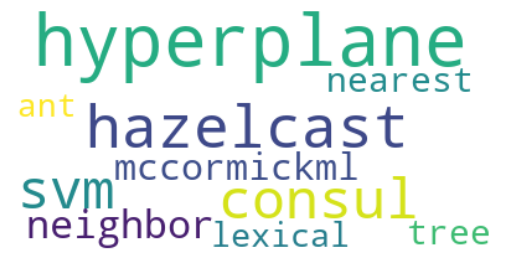

In [117]:
create_wordcloud_lda(top_n_words[180])

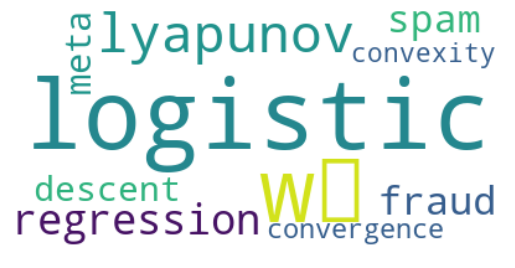

In [118]:
create_wordcloud_lda(top_n_words[201])

### Library

In [29]:
topic_model = BERTopic(language="multilingual", verbose=True,
                       calculate_probabilities=True)

In [30]:
topics, probs = topic_model.fit_transform(filtered_docs)

Batches:   0%|          | 0/311 [00:00<?, ?it/s]

2022-12-20 10:21:40,472 - BERTopic - Transformed documents to Embeddings
2022-12-20 10:22:05,308 - BERTopic - Reduced dimensionality
2022-12-20 10:22:11,074 - BERTopic - Clustered reduced embeddings


In [31]:
topic_model.visualize_topics()

In [35]:
topic_model.visualize_distribution(probs[200], min_probability=0.0025)

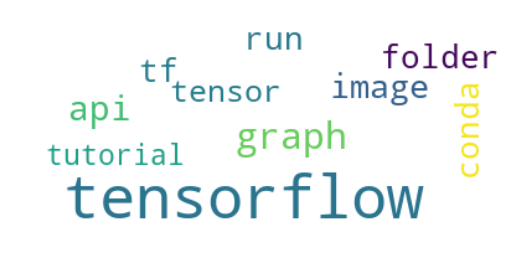

In [151]:
create_wordcloud(topic_model, 42)

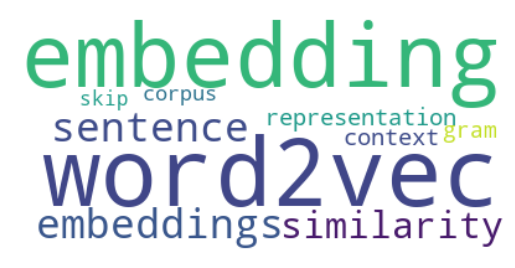

In [154]:
create_wordcloud(topic_model, 14)

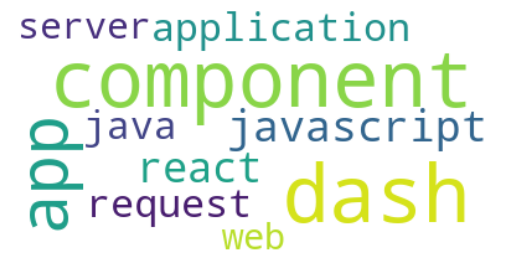

In [153]:
create_wordcloud(topic_model, 9)

In [33]:
topic_model.visualize_hierarchy(top_n_topics=25, orientation="left")

In [34]:
topic_model.visualize_barchart(top_n_topics=8)

In [157]:
topic_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)

In [51]:
topic_model.save(os.path.join(MODELS_DATA_PATH, "bertopic.hd5"))	

In [40]:
key_words = {
    'key_word_1' : [topic_model.get_topic(topic)[0][0] for topic in topics],
    'key_word_2' : [topic_model.get_topic(topic)[1][0] for topic in topics],
    'key_word_3' : [topic_model.get_topic(topic)[2][0] for topic in topics],
    'key_word_4' : [topic_model.get_topic(topic)[3][0] for topic in topics],
}

In [49]:
df["topic"] = topics

In [37]:
means = []
for topic in topics:
    means.append(topic_model.get_topic(topic)[0][0])

In [50]:
df["topic_name"] = means

In [55]:
topic_model.get_topic(-1)

[('image', 0.0037492751294000365),
 ('user', 0.003548218099473448),
 ('could', 0.0034774535464469243),
 ('life', 0.0034678604499722866),
 ('business', 0.003410526262315623),
 ('year', 0.0033542456807793457),
 ('product', 0.0032784580845615246),
 ('go', 0.003182336521485865),
 ('may', 0.0031702644269736924),
 ('look', 0.0031114317535265498)]

In [43]:
df

,title,publication,link,author,followers,reading_time,n_words,pure_text,date,responses,...,month,dow,language,season,topic,topic_name,key_word_1,key_word_2,key_word_3,key_word_4
0,Hands-on Graph Neural Networks with PyTorch & ...,Towards Data Science,https://towardsdatascience.com/hands-on-graph-...,"Kung-Hsiang, Huang (Steeve)",3900,9,1615,"In my last article, I introduced the concept o...",30/05/2019,17,...,May,Thursday,en,spring,41,graph,graph,node,edge,gnns
1,An Easy Introduction to SQL for Data Scientists,Towards Data Science,https://towardsdatascience.com/an-easy-introdu...,George Seif,21000,8,742,Want to be inspired? Come join my Super Quotes...,30/05/2019,1,...,May,Thursday,en,spring,67,sql,sql,query,database,table
2,A Step-by-Step Implementation of Gradient Desc...,Towards Data Science,https://towardsdatascience.com/a-step-by-step-...,Yitong Ren,332,4,534,The original intention behind this post was me...,30/05/2019,4,...,May,Thursday,en,spring,7,descent,descent,minimum,sgd,stochastic
3,Introduction to Latent Matrix Factorization Re...,Towards Data Science,https://towardsdatascience.com/introduction-to...,Tumas Rackaitis,37,5,860,Latent Matrix Factorization is an incredibly p...,30/05/2019,2,...,May,Thursday,en,spring,34,item,item,recommendation,netflix,recommender
4,Databricks: How to Save Data Frames as CSV Fil...,Towards Data Science,https://towardsdatascience.com/databricks-how-...,Deborah Kewon,129,4,633,When I work on Python projects dealing with la...,30/05/2019,4,...,May,Thursday,en,spring,-1,business,business,image,could,product
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9928,Improving Sprint Predictability in Agile Scrum,Better Programming,https://betterprogramming.pub/improving-sprint...,Glamredhel,16,11,1724,After the successful application of the framew...,09/01/2022,1,...,January,Sunday,en,winter,-1,business,business,image,could,product
9929,How to Transition to a Product Management Role,Better Programming,https://betterprogramming.pub/how-to-transitio...,Olaseni Adeniji,514,6,1291,Have you ever wondered what it takes to switch...,10/01/2022,0,...,January,Monday,en,winter,4,team,team,employee,leader,manager
9930,10 Tips To Write Effective Code Reviews,Better Programming,https://betterprogramming.pub/10-tips-to-write...,Meriç Melike Yılmaz,233,10,2118,We have all seen those code reviews where the ...,14/01/2022,1,...,January,Friday,en,winter,-1,business,business,image,could,product
9931,Is Workplace Stress Overwhelming You? Here Are...,Better Programming,https://betterprogramming.pub/is-workplace-str...,Vinita,1920,9,1485,"Work is a big part of our life. Done well, it ...",25/01/2022,2,...,January,Tuesday,en,winter,0,life,life,feel,something,sleep


In [59]:
# assert len(key_words["key_word_1"]) == df.shape[0]

In [30]:
# keyword_columns = [f"key_word_{i}" for i in range(1,11)]

In [48]:
df['key_word_1'] = key_words['key_word_2']
df['key_word_2'] = key_words['key_word_3']
df['key_word_3'] = key_words['key_word_4']
# df['key_word_5'] = key_words['key_word_5']
# df['key_word_6'] = key_words['key_word_6']
# df['key_word_7'] = key_words['key_word_7']
# df['key_word_8'] = key_words['key_word_8']
# df['key_word_9'] = key_words['key_word_9']
# df['key_word_10'] = key_words['key_word_10']

In [42]:
# all_topics = df[keyword_columns[0]]
# for keyword_column in keyword_columns[1:]:
#         all_topics += " " + df[keyword_column]

In [133]:
# all_topics.drop_duplicates()

In [44]:
df[df["language"] == 'ru'].head(5)

,title,publication,link,author,followers,reading_time,n_words,pure_text,date,responses,...,month,dow,language,season,topic,topic_name,key_word_1,key_word_2,key_word_3,key_word_4
6185,Тестовая версия Баунти-платформы TokenGo,Towards Data Science,https://medium.com/@RU_TokenGo/%D1%82%D0%B5%D1...,TokenGo Platform_RU,294,2,291,Уважаемые участники!Мы уже писали в последних ...,02/04/2018,6,...,April,Monday,ru,spring,-1,business,business,image,could,product
6495,SOCIAL AI,Altsoph’s blog,https://medium.com/altsoph/social-ai-3a6a5913b...,Aleksey Tikhonov,278,2,397,Уже несколько лет я вяло подумываю в очередной...,09/02/2012,0,...,February,Thursday,ru,winter,113,อม,อม,ได,เป,อย
6770,Пошаговое построение логистической регрессии в...,NOP::Nuances of Programming,https://medium.com/nuances-of-programming/%D0%...,Дмитрий ПереводIT,166,9,656,Логистическая регрессия — это алгоритм классиф...,12/07/2020,2,...,July,Sunday,ru,summer,19,logistic,logistic,regression,log,probability
7523,📈 Листинг GoPower (GPT) на бирже DDEX!,Towards Data Science,https://medium.com/@RU_TokenGo/%D0%BB%D0%B8%D1...,TokenGo Platform_RU,294,2,250,GoPower (GPT) успешно торгуется на крупнейшей ...,31/01/2019,0,...,January,Thursday,ru,winter,11,blockchain,blockchain,bitcoin,transaction,cryptocurrency
7700,Мы вводим рейтинг для участников Баунти-кампаний,Towards Data Science,https://medium.com/@RU_TokenGo/%D0%BC%D1%8B-%D...,TokenGo Platform_RU,294,2,372,Уважаемые участники.Мы начинаем разработку рей...,31/03/2018,5,...,March,Saturday,ru,spring,-1,business,business,image,could,product


In [51]:
df.to_csv("scrapped_data/scrapped_data_topics.csv", index=False)

In [200]:
df.isna().sum().sum()

0